# G2Net: GRAVITATIONAL WAVE DETECTION

### TEAM DETAILS :
### (i)
#### * TEAM ID : 05
#### * SEM : 05
#### * DIV : E
#### * DEPT : SCHOOL OF COMPUTER SCIENCE AND ENGINERRING
### (ii)
#### * TITLE ID : 5DMACP07
#### * PROJECT TITLE : G2Net: GRAVITATIONAL WAVE DETECTION
### (iii)
#### * CRISP PROBLEM STATEMENT : DETECTING OF GRAVITIONAL WAVES FROM BINARY BLACK HOLE COLLISIONS
### (iv)
#### * TEAM LEADER : PRADEEP CHEGUR       526 01FE19BCS294
#### * MEMBER 1    : SWAGAT INGALAGAON    529 01FE19BCS299
#### * MEMBER 2    : NAVEEN DODDAMANI     534 01FE19BCS305
#### * MEMBER 3    : PRAVEEN THAKKANNAVAR 528 01FE19BCS298

# STEP 1: EXPLORATORY DATA ANALYSIS

### IMPORTING LIBRARIES:

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
pd.set_option("display.max_colwidth", None) # setting the maximum width in characters when displaying pandas column. "None" value means unlimited.

import matplotlib.pyplot as plt  # plotting
from glob import glob     # pathname management

import random    # generating (pseudo)-random numbers
import seaborn as sns # for data visualization
import matplotlib.mlab as mlab  # some MATLAB commands
from scipy.interpolate import interp1d  # interpolating a 1-D function


### READING A CSV FILE WITH HEADERS:

In [2]:
training_labels=pd.read_csv("../input/g2net-gravitational-wave-detection/training_labels.csv")
training_labels.head()

,id,target
0,00000e74ad,1
1,00001f4945,0
2,0000661522,0
3,00007a006a,0
4,0000a38978,1


In [3]:
training_labels['target'].value_counts()

0    280070
1    279930
Name: target, dtype: int64

In [4]:
training_paths = glob("../input/g2net-gravitational-wave-detection/train/*/*/*/*")
print("The total number of files in the training set:", len(training_paths))

The total number of files in the training set: 560000


#### It turned out to be useful to merge labels and file paths based on their ids.

In [5]:
ids = [path.split("/")[-1].split(".")[0] for path in training_paths]
paths_df = pd.DataFrame({"path":training_paths, "id": ids})
train_data = pd.merge(left=training_labels, right=paths_df, on="id")
train_data.head()

,id,target,path
0,00000e74ad,1,../input/g2net-gravitational-wave-detection/train/0/0/0/00000e74ad.npy
1,00001f4945,0,../input/g2net-gravitational-wave-detection/train/0/0/0/00001f4945.npy
2,0000661522,0,../input/g2net-gravitational-wave-detection/train/0/0/0/0000661522.npy
3,00007a006a,0,../input/g2net-gravitational-wave-detection/train/0/0/0/00007a006a.npy
4,0000a38978,1,../input/g2net-gravitational-wave-detection/train/0/0/0/0000a38978.npy


In [6]:
train_data.to_csv("Path_dataset.csv",index=False)

### PLOTTING ABOVE DATA:

<AxesSubplot:xlabel='target', ylabel='count'>

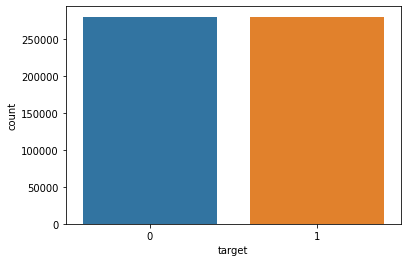

In [7]:
sns.countplot(x=train_data['target'])

#### From above data, we can conclude that the training dataset is much balanced.

#### USING RANDOM LIBRARY TO GET RANDOM SIGNALS.

In [8]:
def load_random_file(signal = None):
    """Selecting a random file from the training dataset. 
    
    Args:
        signal: bool
            optional flag defining whether to select pure detector 
            noise (False) or detector noise plus simulated signal (True).
            If skipped, the flag is chosen randomly.
    Returns:
        file_id: str
            unique id of the selected file
        target: int
            0 or 1, target value
        data: numpy.ndarray
            numpy array in the shape (3, 4096), where 3 is the number
            of detectors, 4096 is number of data points (each time series
            instance spans over 2 seconds and is sampled at 2048 Hz)
        
    """    
    if signal is None:
        signal = random.choice([True, False])
        
    filtered = train_data["target"]==signal   # filtering dataframe based on the target value
    
    index = random.choice(train_data[filtered].index)   # random index 
    
    file_id = train_data['id'].at[index]
    target = train_data['target'].at[index]
    path = train_data['path'].at[index]
    
    data = np.load(path)
    
    return file_id, target, data

### PLOTTING THE RAW DATA IN TIME DOMAIN:

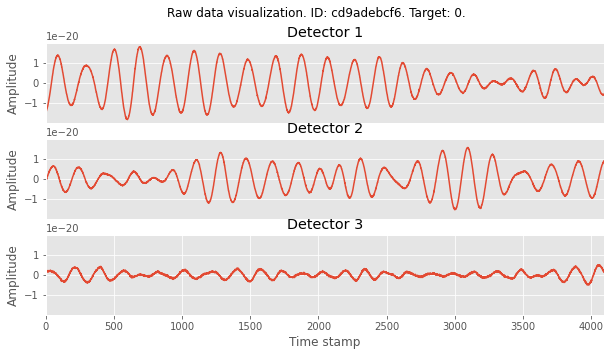

In [9]:
file_id, target, data = load_random_file()
ylim = 1.1*np.max(data)

plt.style.use('ggplot')

fig, axs = plt.subplots(ncols=1, nrows=3, figsize=(10, 5))

for i in range(3):
    ax = axs.ravel()[i]
    ax.plot(data[i])
    ax.margins(0)
    axs[i].set_title(f"Detector {i+1}", loc='center')
    ax.set_ylabel(f"Amplitude")
    ax.set_ylim([-ylim, ylim])
    
axs[0].xaxis.set_visible(False)
axs[1].xaxis.set_visible(False)

axs[2].set_xlabel("Time stamp")
fig.suptitle(f"Raw data visualization. ID: {file_id}. Target: {target}.")
plt.show()

### PLOTTING THE DATA IN FREQUENCY DOMAIN:
#### One of the ways to explore the frequency components of the data, is to plot the amplitude spectral density. Reference Link: https://www.gw-openscience.org/GW150914data/LOSC_Event_tutorial_GW150914.html#Whitening

In [10]:
fs = 2048      # sampling rate
NFFT = 4*fs    # the Nyquist frequency 
f_min = 20.
f_max = fs/2

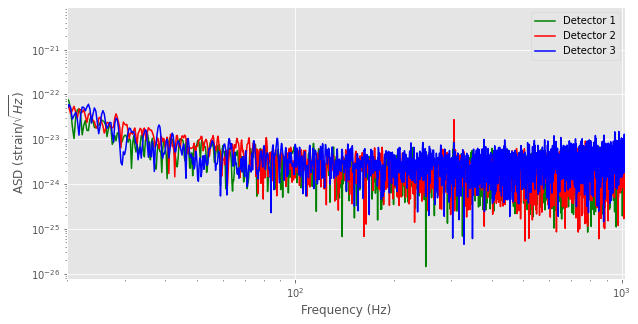

In [11]:
_, target, data = load_random_file(True)

strain1, strain2, strain3 = data[0], data[1], data[2]

Pxx_1, freqs = mlab.psd(strain1, Fs = fs, NFFT = NFFT)
Pxx_2, freqs = mlab.psd(strain2, Fs = fs, NFFT = NFFT)
Pxx_3, freqs = mlab.psd(strain3, Fs = fs, NFFT = NFFT)

psd_1 = interp1d(freqs, Pxx_1)
psd_2 = interp1d(freqs, Pxx_2)
psd_3 = interp1d(freqs, Pxx_3)

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 5))
ax.loglog(freqs, np.sqrt(Pxx_1),"g",label="Detector 1")
ax.loglog(freqs, np.sqrt(Pxx_2),"r",label="Detector 2")
ax.loglog(freqs, np.sqrt(Pxx_3),"b",label="Detector 3")

ax.set_xlim([f_min, f_max])
ax.set_ylabel("ASD (strain/$\sqrt{Hz}$)")
ax.set_xlabel("Frequency (Hz)")
ax.legend()

plt.show()

### CONSTANT Q-TRANSFORM:

#### Another very common way to visualize a GW signal is to perform a constant Q-transform (or CQT). This is a time-frequency representation widely used in processing musical data. Reference Link: http://pycbc.org/pycbc/latest/html/.

In [12]:
!pip -q install pycbc
import pycbc

#### We can use some helper functions to generate and visualize Q-transforms. Some useful codes with PyCBC methods given here: https://github.com/gwastro/PyCBC-Tutorials.

In [13]:
def generate_qtransform(data, fs):
    """Function for generating constant Q-transform. 
    
    Args:
        data: numpy.ndarray
            numpy array in the shape (3, 4096), where 3 is the number
            of detectors, 4096 is number of data points (each time series
            instance spans over 2 seconds and is sampled at 2048 Hz)
        fs: int
            sampling frequency
    Returns:
        times: numpy.ndarray
            array of time bins
        freqs: numpy.ndarray
            array of frequency bins
        qplanes: list
            list with 3 elements corresponding to each detector in the raw
            data file. Each element is a 2-d vector of the power in each 
            time-frequency bin
    """    
    
    qplanes = []
    for i in range(len(data)):
        
        # converting data into PyCBC Time Series format
        ts = pycbc.types.TimeSeries(data[i, :], epoch=0, delta_t=1.0/fs)   
        
        # whitening the data within some frequency range
        ts = ts.whiten(0.125, 0.125) 
        
        # calculating CQT values
        times, freqs, qplane = ts.qtransform(.002, logfsteps=100, qrange=(10, 10), frange=(20, 512))

        qplanes.append(qplane)
        
    return times, freqs, qplanes 

In [14]:
def plot_qtransform(file_id, target, data):
    """Plotting constant Q-transform data.
    
    Args:
        file_id: str
            unique id of the selected file
        target: int
            0 or 1, target value
        data: numpy.ndarray
            numpy array in the shape (3, 4096), where 3 is the number
            of detectors, 4096 is number of data points (each time series
            instance spans over 2 seconds and is sampled at 2048 Hz)
    """
    
    times, freqs, qplanes = generate_qtransform(data, fs=fs)
    
    fig, axs = plt.subplots(ncols=1, nrows=3, figsize=(12, 8))

    for i in range(3):

        axs[i].pcolormesh(times, freqs, qplanes[i], shading = 'auto')
        axs[i].set_yscale('log')
        axs[i].set_ylabel('Frequency (Hz)')
        axs[i].set_xlabel('Time (s)')
        axs[i].set_title(f"Detector {i+1}", loc='left')
        axs[i].grid(False)

    axs[0].xaxis.set_visible(False)
    axs[1].xaxis.set_visible(False)

    fig.suptitle(f"Q transform visualization. ID: {file_id}. Target: {target}.", fontsize=16)
    plt.show()

#### Now we can select a random data file, perform CQT and plot the results.

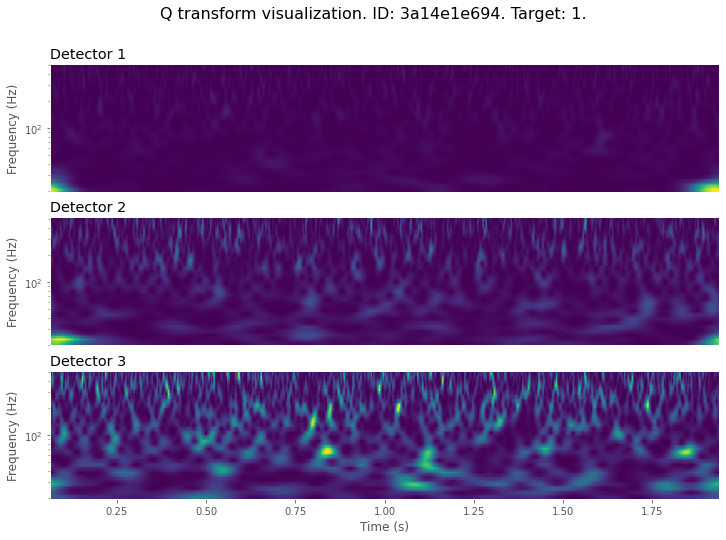

In [15]:
file_id, target, data = load_random_file()
plot_qtransform(file_id, target, data)

#### If we select a strong GW signal rather than selecting a random signal which is characterized by a frequency change on the CQT spectrogram. Selected sample from ../input/g2net-gravitational-wave-detection/train/7/9/4.

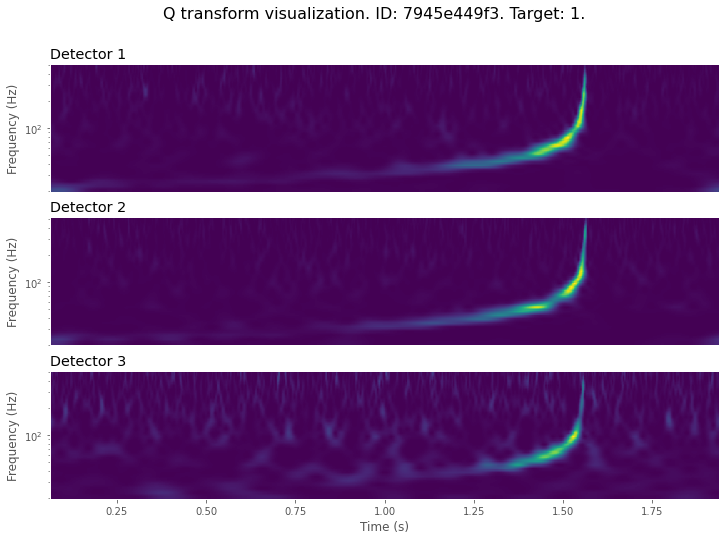

In [16]:
file_id = '7945e449f3'
target = 1
data  = np.load(train_data[train_data['id']==file_id]['path'].values[0])

plot_qtransform(file_id, target, data)

# STEP 2: PRE-PROCESSING OF GIVEN DATA

### ABOUT GIVEN DATA
#### Applying some signal processing to the training data. Preprocessing is definately required on these signals, and there is a Python package called GWPY that has all functions that are needed for pre-processing. Data cleaning here is about cleaning of digital signals- applying standard steps specific to "Digital Signal Processing". Referred links:
  * https://gwpy.github.io/docs/latest/index.html
  * https://www.gw-openscience.org/tutorials/
  * https://www.gw-openscience.org/software/
  * https://iopscience.iop.org/article/10.1088/1361-6382/ab685e
  
  

### INSTALLING GWPY

In [17]:
!python -m pip install gwpy
!pip install astropy==4.2.1

     |████████████████████████████████| 1.4 MB 807 kB/s 
     |████████████████████████████████| 9.7 MB 803 kB/s 
  Attempting uninstall: astropy
    Found existing installation: astropy 4.3.1
    Uninstalling astropy-4.3.1:
      Successfully uninstalled astropy-4.3.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pycbc 1.18.3 requires astropy!=4.0.5,!=4.2.1,>=2.0.3; python_version > "3.0", but you have astropy 4.2.1 which is incompatible.


#### IMPORTING LIBRARIES:

In [18]:
from gwpy.timeseries import TimeSeries # time domain data array in gwpy
from gwpy.plot import Plot # plotting in gwpy
from scipy import signal # for signal processing
from sklearn.preprocessing import MinMaxScaler # for preprocessing


#### Defining a function to read numpy data and convert into GWpy TimeSeries format and plot the data. All the files are 2s recordings at 2048Hz sample rate from the 3 detectors.

In [19]:
def read_file(fname):
    data = np.load(fname)
    d1 = TimeSeries(data[0,:], sample_rate=2048)
    d2 = TimeSeries(data[1,:], sample_rate=2048)
    d3 = TimeSeries(data[2,:], sample_rate=2048)
    return d1, d2, d3

def plot_time_data(d1, d2, d3):
    plot = Plot(d1, d2, d3, separate=True, sharex=True, figsize=[12, 8])
    ax = plot.gca()
    ax.set_xlim(0,2)
    ax.set_xlabel('Time [s]')
    plot.show()

#### VISUALIZING A SINGLE DATA:

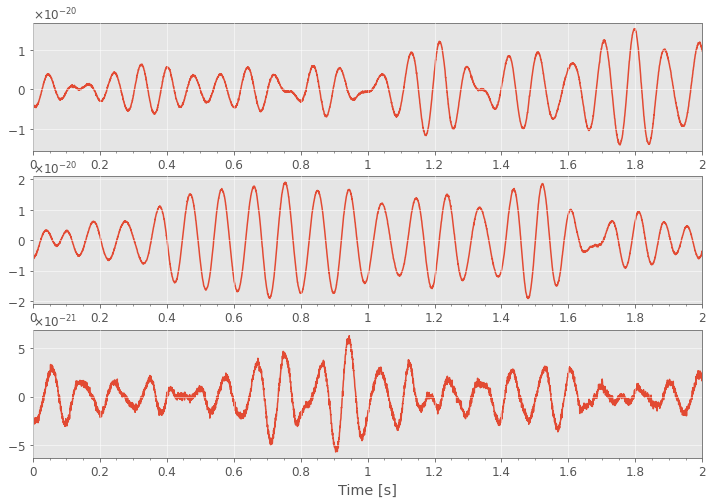

In [20]:
d1, d2, d3 = read_file('../input/g2net-gravitational-wave-detection/train/0/0/0/000a5b6e5c.npy')
plot_time_data(d1, d2, d3)

### PRE-PROCESSING STEPS:
#### General pre-processing are: Referred Link: https://iopscience.iop.org/article/10.1088/1361-6382/ab685e  
1. Applying a window function (Tukey - tapered cosine window) to suppress spectral leakage
2. Whitening the spectrum
3. Bandpass

### APPLYING A WINDOW FUNCTION:
#### The Tukey window looks like this:

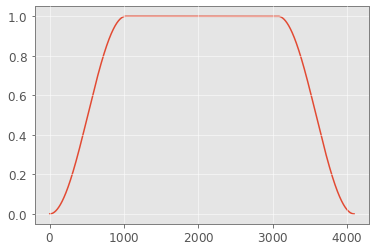

In [21]:
window = signal.tukey(4096)
plt.plot(window);

#### Signal after windowing:

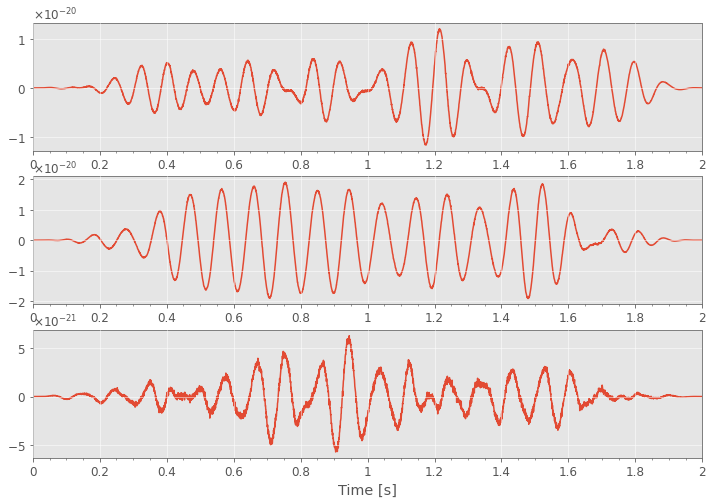

In [22]:
d1, d2, d3 = d1*window, d2*window, d3*window
plot_time_data(d1, d2, d3)

#### Having a look at signal spectrum before applying other two steps:

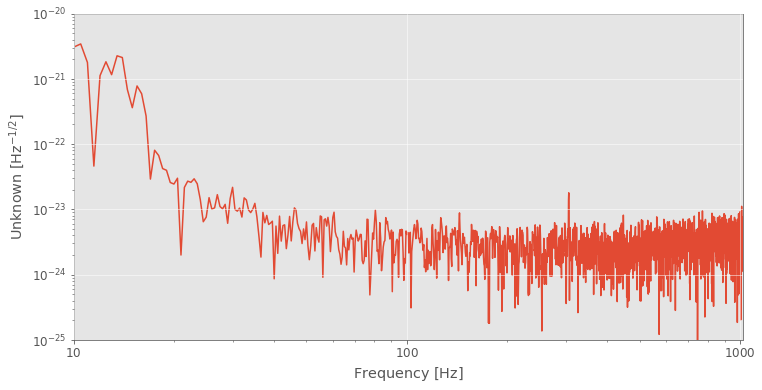

In [23]:
fig2 = d1.asd(fftlength=2).plot(figsize=[12, 6])
plt.xlim(10,1024)
plt.ylim(1e-25, 1e-20);

#### Above spectrum indicates that there is a lot of low frequency noise. Hence moving on to next steps.

#### SPECTRAL WHITENING AND BANDPASS FILTERING:

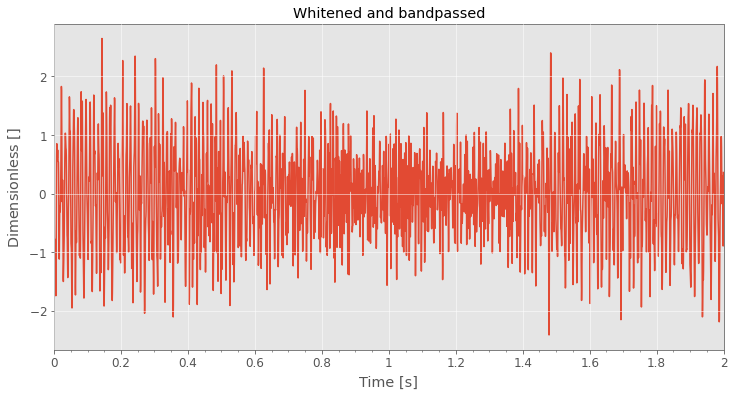

In [24]:
white_data = d1.whiten(window=("tukey",0.2)) # whiten-function has a built-in window function
bp_data = white_data.bandpass(35, 350) # frequency range 35-350Hz
fig3 = bp_data.plot(figsize=[12, 6])
plt.xlim(0, 2)
ax = plt.gca()
ax.set_title('Whitened and bandpassed')
ax.set_xlabel('Time [s]');

#### Now the spectrum is in allmost in steady state.

In [25]:
!pip install -q nnAudio -qq
import torch
from nnAudio.Spectrogram import CQT1992v2

In [26]:
def convert_image_id_2_path(image_id: str, is_train: bool = True) -> str:
    folder = "train" if is_train else "test"
    return "../input/g2net-gravitational-wave-detection/{}/{}/{}/{}/{}.npy".format(
        folder, image_id[0], image_id[1], image_id[2], image_id 
    )

In [27]:
def visualize_sample(
    _id, 
    target, 
    colors=("black", "red", "green"), 
    signal_names=("LIGO Hanford", "LIGO Livingston", "Virgo")
):
    path = convert_image_id_2_path(_id)
    x = np.load(path)
    plt.figure(figsize=(16, 7))
    for i in range(3):
        plt.subplot(4, 1, i + 1)
        plt.plot(x[i], color=colors[i])
        plt.legend([signal_names[i]], fontsize=12, loc="lower right")
        
        plt.subplot(4, 1, 4)
        plt.plot(x[i], color=colors[i])
    
    plt.subplot(4, 1, 4)
    plt.legend(signal_names, fontsize=12, loc="lower right")

    plt.suptitle(f"id: {_id} target: {target}", fontsize=16)
    plt.show()

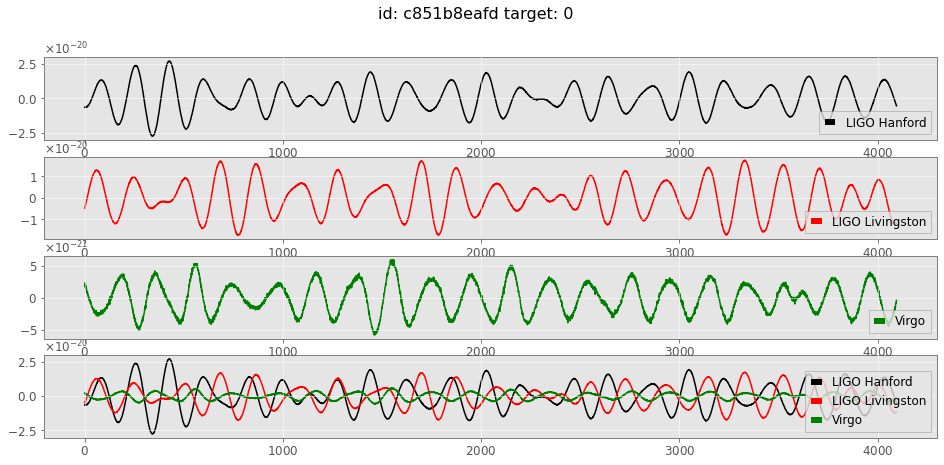

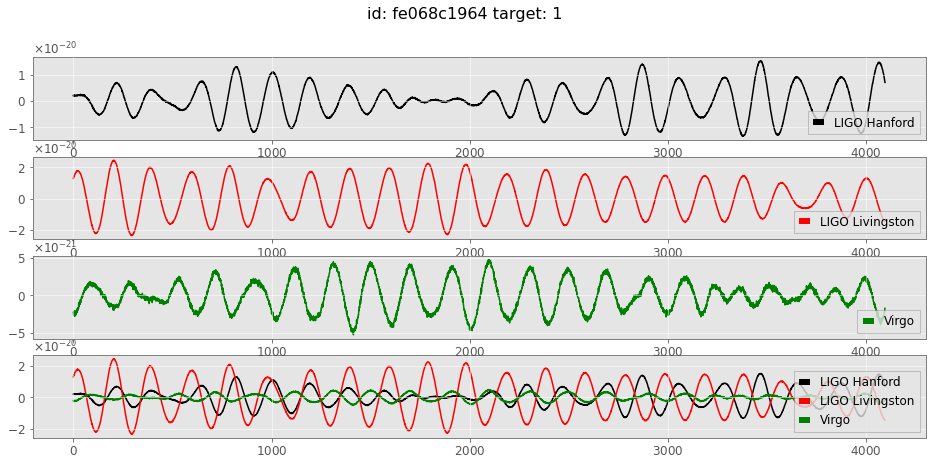

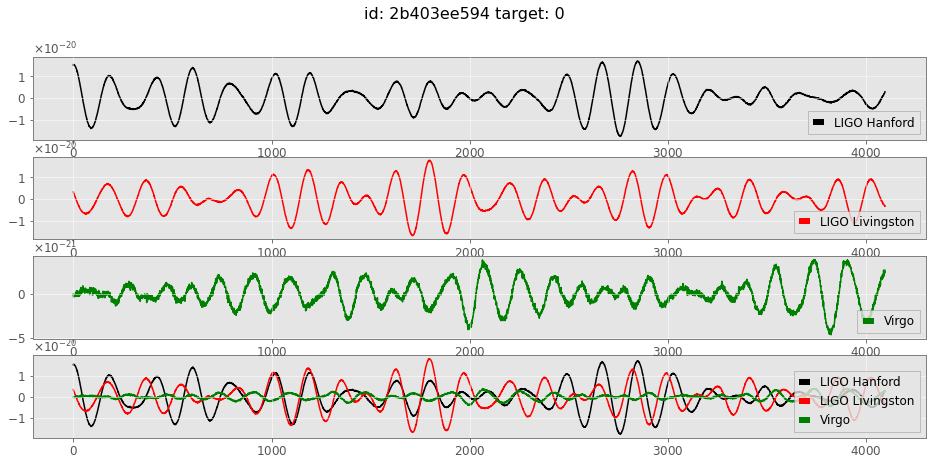

In [28]:
for i in random.sample(train_data.index.tolist(), 3):
    _id = train_data.iloc[i]["id"]
    target = train_data.iloc[i]["target"]

    visualize_sample(_id, target)

In [29]:
Q_TRANSFORM = CQT1992v2(sr=2048, fmin=20, fmax=1024, hop_length=32)

def visualize_sample_qtransform(
    _id, 
    target,
    signal_names=("LIGO Hanford", "LIGO Livingston", "Virgo"),
    sr=2048,
):
    x = np.load(convert_image_id_2_path(_id))
    plt.figure(figsize=(16, 5))
    for i in range(3):
        waves = x[i] / np.max(x[i])
        waves = torch.from_numpy(waves).float()
        image = Q_TRANSFORM(waves)
        
        plt.subplot(1, 3, i + 1)
        plt.imshow(image.squeeze())
        plt.title(signal_names[i], fontsize=14)

    plt.suptitle(f"id: {_id} target: {target}", fontsize=16)
    plt.show()

CQT kernels created, time used = 0.0448 seconds


/opt/conda/lib/python3.7/site-packages/nnAudio/utils.py:326: SyntaxWarning: If fmax is given, n_bins will be ignored
  warnings.warn('If fmax is given, n_bins will be ignored',SyntaxWarning)


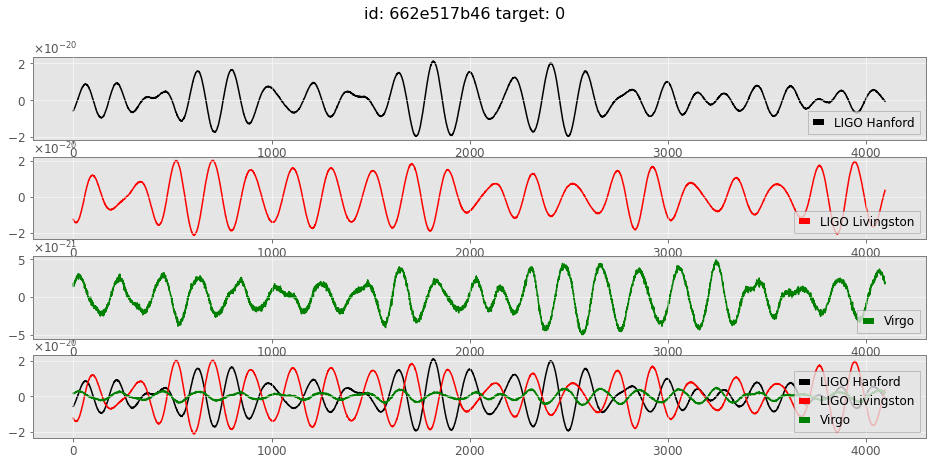

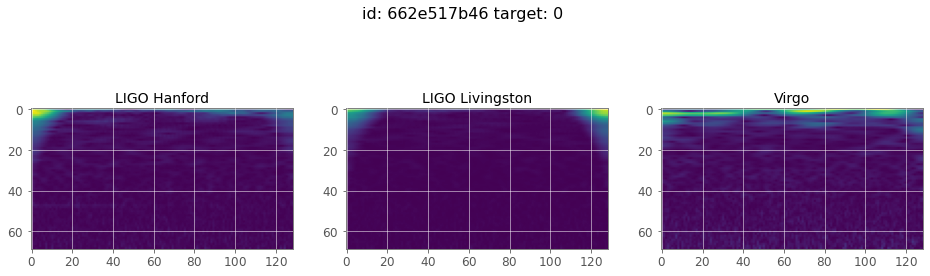

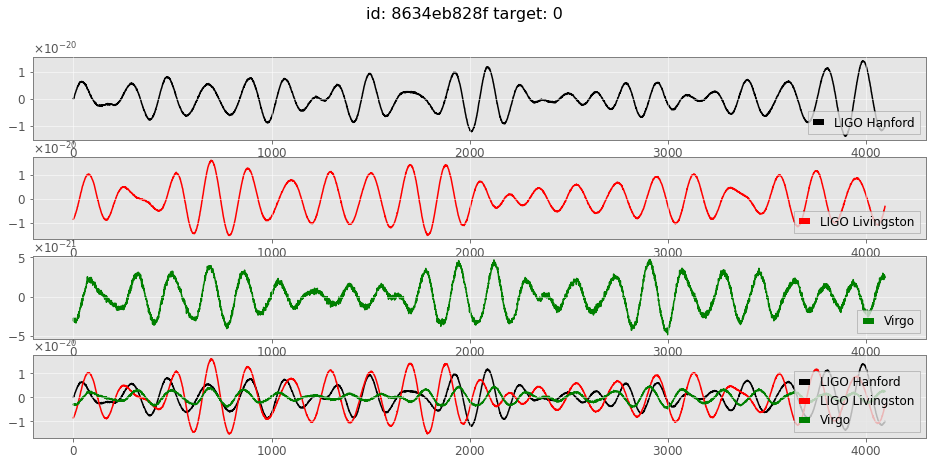

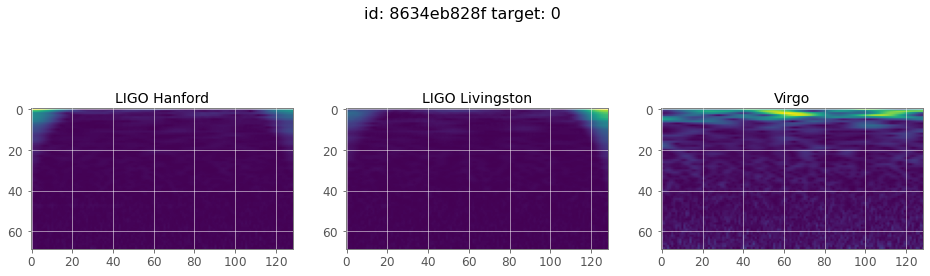

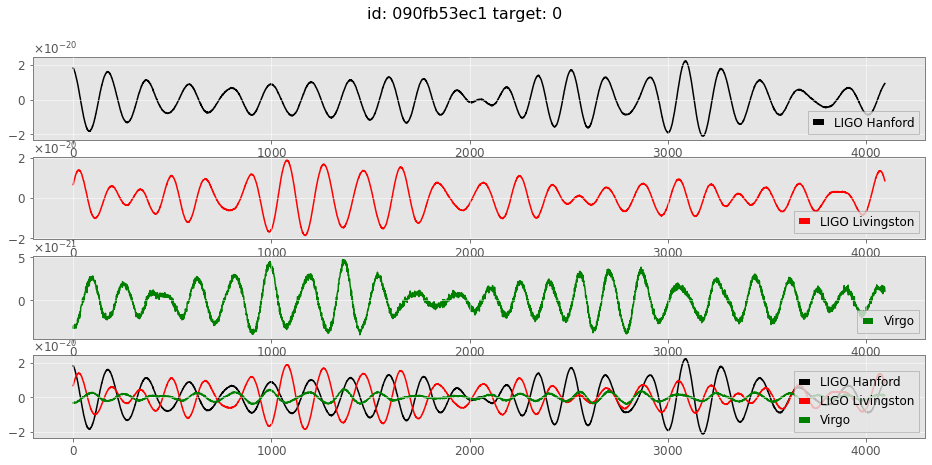

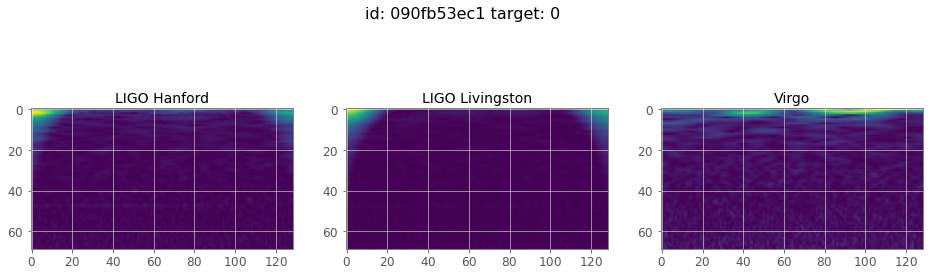

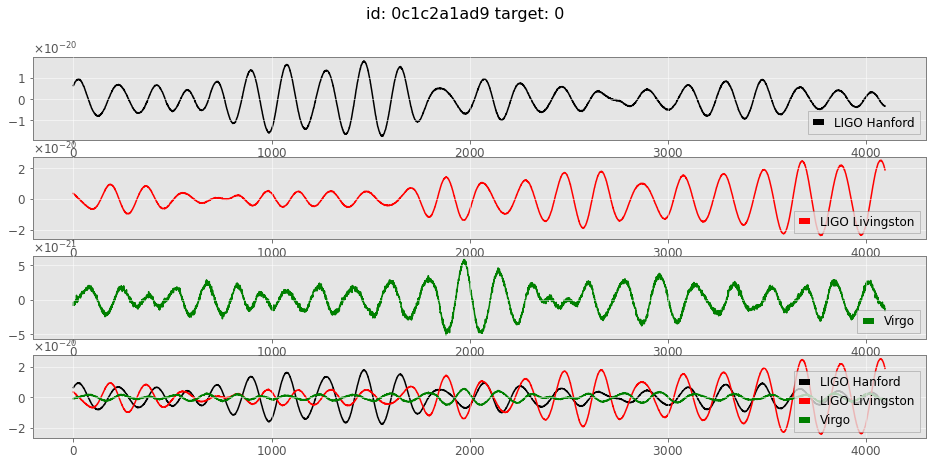

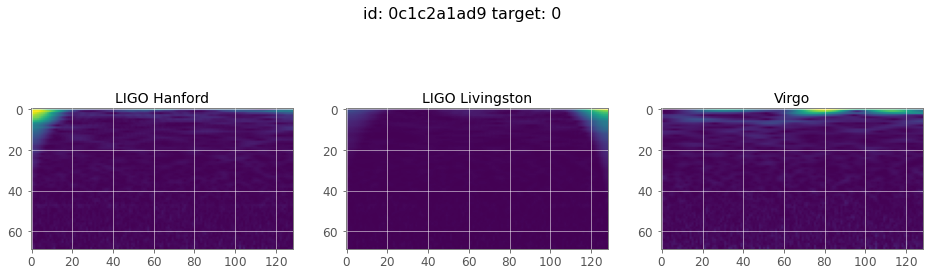

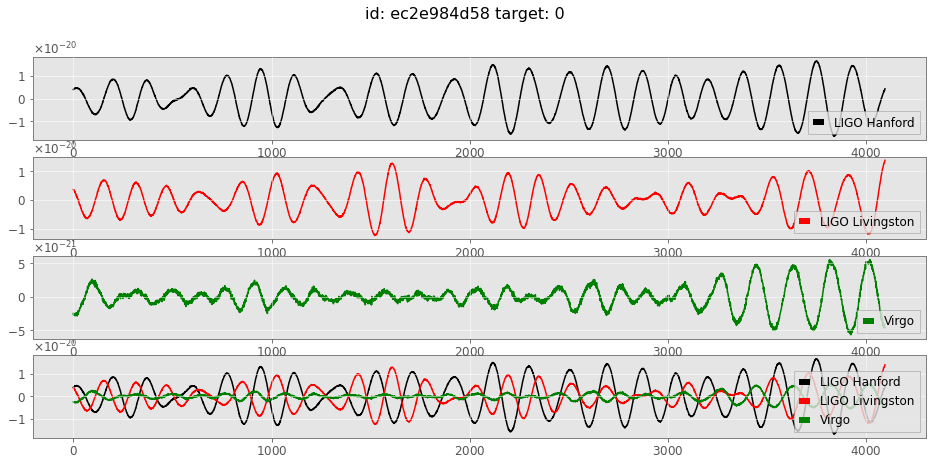

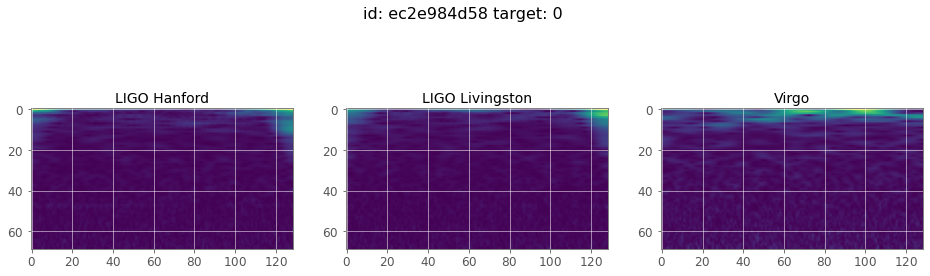

In [30]:
for i in random.sample(train_data.index.tolist(), 5):
    _id = train_data.iloc[i]["id"]
    target = train_data.iloc[i]["target"]

    visualize_sample(_id, target)
    visualize_sample_qtransform(_id, target)

# STEP 3: BUILDING A MODEL

In [31]:
!python -m pip install gwpy

In [32]:
!pip install -q nnAudio -qq

In [33]:

from scipy import signal
from gwpy.timeseries import TimeSeries
from gwpy.plot import Plot
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from PIL import Image
from glob import glob
from matplotlib import pyplot as plt
import random
from colorama import Fore, Back, Style
plt.style.use('ggplot')
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split

from tensorflow.keras.utils import Sequence

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv1D, MaxPool1D, BatchNormalization
from tensorflow.keras.optimizers import RMSprop, Adam

import torch
from nnAudio.Spectrogram import CQT1992v2

In [34]:
""" First, we define the constructor to initialize the configuration of the generator.
Note that here, we assume the path to the data is in a dataframe column.

"""

class DataGenerator(Sequence):

    # For this dataset the list_IDs are the value of the ids
    # for each of the time-series file
    # i.e. for Train data => values of column 'id' from training_labels.csv

    # Also Note we have earlier defined our labels to be the below
    # labels = pd.read_csv(root_dir + "training_labels.csv")
    # and the argument "data" is that label here.
    def __init__(self, path, list_IDs, data, batch_size):
        self.path = path
        self.list_IDs = list_IDs
        self.data = data
        self.batch_size = batch_size
        self.indexes = np.arange(len(self.list_IDs))

    """ __len__ essentially returns the number of steps in an epoch, using the samples and the batch size.
        Each call requests a batch index between 0 and the total number of batches, where the latter is specified in the __len__ method.
        A common practice is to set this value to (samples / batch size)
        so that the model sees the training samples at most once per epoch.
        Now, when the batch corresponding to a given index is called, the generator executes the __getitem__ method to generate it.
    """

    def __len__(self):
        len_ = int(len(self.list_IDs)/self.batch_size)
        if len_ * self.batch_size < len(self.list_IDs):
            len_ += 1
        return len_

    """  __getitem__ method is called with the batch number as an argument to obtain a given batch of data.

    """
    def __getitem__(self, index):
        # get the range to to feed to keras for each epoch
        # incrementing by +1 the bath_size
        indexes = self.indexes[index * self.batch_size : (index + 1) * self.batch_size]
        list_IDs_temp = [self.list_IDs[k] for k in indexes]
        X, y = self.__data_generation(list_IDs_temp)
        return X, y

    """ And finally the core method which will actually produce batches of data. This private method __data_generation """

    def __data_generation(self, list_IDs_temp):
        # We have 5,60,000 files, each with dimension of 3 * 4096
        X = np.zeros((self.batch_size, 3, 4096))
        y = np.zeros((self.batch_size, 1))
        for i, ID in enumerate(list_IDs_temp):
            id_ = self.data.loc[ID, "id"]
            file = id_ + ".npy"  # build the file name
            path_in = "/".join([self.path, id_[0], id_[1], id_[2]]) + "/"
            # there are three nesting labels inside train/ or test/
            data_array = np.load(path_in + file)            
            data_array = (data_array - data_array.mean())/data_array.std()
            X[i, ] = data_array
            y[i, ] = self.data.loc[ID, 'target']
        # print(X)
        return X, y

In [35]:
root_dir = "../input/g2net-gravitational-wave-detection/"

In [36]:
train_labels = pd.read_csv(root_dir + "/training_labels.csv")

In [37]:
sample_submission = pd.read_csv(root_dir +  'sample_submission.csv')
# print(len(train_labels)) # 5,60,000
# print(len(sample_submission)) # 2,26,000
train_ids = train_labels['id'].values
# train_ids # ['00000e74ad', '00001f4945', '0000661522' ... ]
y = train_labels['target'].values
test_ids = sample_submission['id'].values

In [38]:
# train_labels = pd.read_csv(root_dir + "training_labels.csv", nrows=1000)
# Now I shall genereate train indices, validation indices and test indices
# Which are just the values from the 0-based indices
train_indices, validation_indices = train_test_split(list(train_labels.index), test_size=0.33, random_state=2021)
# print(len(train_indices))
print(len(validation_indices))
test_indices = list(sample_submission.index)
# test_indices

184800


In [39]:
train_generator_for_seq_model = DataGenerator( root_dir +  'train/', train_indices, train_labels, 64)
# print(train_generator_for_seq_model)
validation_generator_for_seq_model = DataGenerator( root_dir + 'train/', validation_indices, train_labels, 64)
test_generator_for_seq_model = DataGenerator( root_dir + 'test/', test_indices, sample_submission, 64)

In [40]:
model_keras_seq = Sequential()
model_keras_seq.add(Conv1D(64, input_shape=(3, 4096), kernel_size=3, activation='relu'))
model_keras_seq.add(BatchNormalization())
model_keras_seq.add(Flatten())
model_keras_seq.add(Dense(64, activation='relu'))
model_keras_seq.add(Dense(1, activation='sigmoid'))

model_keras_seq.compile(optimizer= Adam(lr=2e-4), loss='binary_crossentropy', metrics=['acc'])
model_keras_seq.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1, 64)             786496    
_________________________________________________________________
batch_normalization (BatchNo (None, 1, 64)             256       
_________________________________________________________________
flatten (Flatten)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 790,977
Trainable params: 790,849
Non-trainable params: 128
_________________________________________________________________


In [41]:
history = model_keras_seq.fit_generator(generator=train_generator_for_seq_model, validation_data=validation_generator_for_seq_model, epochs = 1, workers=-1)
# 1 Epoch took around 2 and half hours

predicted_test_seq_keras = model_keras_seq.predict_generator(test_generator_for_seq_model, verbose=1)

sample_submission['target'] = predicted_test_seq_keras[:len(sample_submission)]

sample_submission.to_csv('submission.csv', index=False)

3532/3532 [==============================] - 1729s 490ms/step


In [42]:
sample_submission

,id,target
0,00005bced6,0.579148
1,0000806717,0.529871
2,0000ef4fe1,0.496151
3,00020de251,0.510538
4,00024887b5,0.524581
...,...,...
225995,ffff4125f1,0.516323
225996,ffff9d32a6,0.464461
225997,ffff9f4c1f,0.523643
225998,ffffa19693,0.543304
